In [1]:
# Automatically reload changes to external code
%load_ext autoreload
%autoreload 2

In this assignment, you will solve a classic control problem - CartPole using policy gradient methods.

Policy gradient method is a family of RL algorithms that parameterizes the policy directly. The simplest advantage that policy parameterization may have over action-value parameterization is that the policy may be a simpler function to approximate.

First, you will implement the "vanilla" policy gradient method, i.e., a method that repeatedly computes **unbiased** estimates $\hat{g}$ of $\nabla_{\theta} E[\sum_t r_t]$ and takes gradient ascent steps $\theta \rightarrow \theta + \epsilon \hat{g}$ so as to increase the total rewards collected in each episode. To make sure our code can solve multiple MDPs with different policy parameterizations, provided code follows an OOP manner and represents MDP and Policy as classes.

The following code constructs an instance of the MDP using OpenAI gym.

In [2]:
import gym
import tensorflow as tf
import numpy as np
from policy_gradient import util
from policy_gradient.policy import CategoricalPolicy
from policy_gradient.baselines.linear_feature_baseline import LinearFeatureBaseline
from gym.spaces import prng

# CartPole-v0 is a MDP with finite state and action space. 
# In this environment, A pendulum is attached by an un-actuated joint to a cart, 
# and the goal is to prevent it from falling over. You can apply a force of +1 or -1 to the cart.
# A reward of +1 is provided for every timestep that the pendulum remains upright. 
# To visualize CartPole-v0, please see https://gym.openai.com/envs/CartPole-v0
seed = 1
env = gym.make('CartPole-v0')

## Problem 1: construct a neural network to represent policy

Make sure you know how to construct neural network using tensorflow.

1. Open **homework2/policy_gradient/policy.py**.
2. Follow the instruction of Problem 1.

## Problem 2: compute the surrogate loss

If there are $N$ episodes in an iteration, then for $i$ th episode we define $R_t^i = \sum_{{t^′}=t}^T \gamma^{{t^′}-t}r(s_{t^′}, a_{t^′})$ as the accumulated discounted rewards from timestep $t$ to the end of that episode, where $\gamma$ is the discount rate.

The pseudocode for the REINFORCE algorithm is as below:

1. Initialize policy $\pi$ with parameter $\theta_1$.
2. For iteration $k = 1, 2, ...$:
    * Sample N episodes $\tau_1, \tau_2, ..., \tau_N$ under the current policy $\theta_k$, where $\tau_i =(s_i^t,a_i^t,R_i^t)_{t=0}^{T−1}$. Note that the last state is dropped since no action is taken after observing the last state.
    * Compute the empirical policy gradient using formula: $$\hat{g} = E_{\pi_\theta}[\nabla_{\theta} log\pi_\theta(a_t^i | s_t^i) R_t^i]$$
    * Take a gradient step: $\theta_{k+1} = \theta_k + \epsilon \hat{g}$.
    
    
Note that we can transform the policy gradient formula as

$$\hat{g} = \nabla_{\theta} \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) *R_t^i)$$

and $L(\theta) = \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) *R_t^i)$ is called the surrogate loss. 

We can first construct the computation graph for $L(\theta)$, and then take its gradient as the empirical policy gradient.


1. Open **homework2/policy_gradient/policy.py**.
2. Follow the instruction of Problem 2.

In [3]:
# Construct a neural network to represent policy which maps observed state to action.
# following function extract num feature and action from Box and Discreate
in_dim = util.flatten_space(env.observation_space)
out_dim = util.flatten_space(env.action_space)
hidden_dim = 8

# Problem 3

Use baseline to reduce the variance of our gradient estimate.

Change the loss term: 

$$L(\theta) = \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) *R_t^i)$$

into this one

$$L(\theta) = \frac{1}{(NT)}(\sum_{i=1}^N \sum_{t=0}^T log\pi_\theta(a_t^i | s_t^i) *(R_t^i-V_t^i))$$

where $V_t^i$ is the baseline prediction for at the $t$ timestep $i^{th}$ trajectory. In this part, we use a simple linear function to parameterize value function. (You're encouraged to see the details in ```policy_gradient/baselines/linear_feature_baseline.py```)

1. Fill in the function `process_paths` of class `PolicyOptimizer` below.

In [4]:
class PolicyOptimizer(object):
    def __init__(self, env, policy, baseline, n_iter, n_episode, path_length,
        discount_rate=.99):

        self.policy = policy
        self.baseline = baseline
        self.env = env
        self.n_iter = n_iter
        self.n_episode = n_episode
        self.path_length = path_length
        self.discount_rate = discount_rate

    def sample_path(self):
        obs = []
        actions = []
        rewards = []
        ob = self.env.reset()
        #print('ob:', ob)
        # sample a batch of trajectory
        for _ in range(self.path_length):
            a = self.policy.act(ob.reshape(1, -1))
            #print('a', a)
            next_ob, r, done, _ = self.env.step(a)
            obs.append(ob)
            actions.append(a)
            rewards.append(r)
            ob = next_ob
            if done:
                break

        return dict(
            observations=np.array(obs),
            actions=np.array(actions),
            rewards=np.array(rewards),
        )

    def process_paths(self, paths):
        for p in paths:
            if self.baseline != None:
                b = self.baseline.predict(p)
                b[-1] = 0 # terminal state
            else:
                b = 0
            
            # `p["rewards"]` is a matrix contains the rewards of each timestep in a sample path
            r = util.discount_cumsum(p["rewards"], self.discount_rate)
            
            """
            Problem 3:

            1. Variable `b` is the values predicted by our baseline
            2. Use it to reduce variance and then assign the result to the 
                    variable `a` (baseline reduction)

            Sample solution should be only 1 line.
            """
            # YOUR CODE HERE >>>>>>
            a = r-b
            # <<<<<<<<

            p["returns"] = r
            p["baselines"] = b
            p["advantages"] = (a - a.mean()) / (a.std() + 1e-8) # normalize

        obs = np.concatenate([ p["observations"] for p in paths ])
        actions = np.concatenate([ p["actions"] for p in paths ])
        rewards = np.concatenate([ p["rewards"] for p in paths ])
        advantages = np.concatenate([ p["advantages"] for p in paths ])

        return dict(
            observations=obs,
            actions=actions,
            rewards=rewards,
            advantages=advantages,
        )

    
    def train(self):
        loss_list = []
        avg_return_list = []
        for i in range(1, self.n_iter + 1):
            paths = []
            for _ in range(self.n_episode):
                paths.append(self.sample_path())
            data = self.process_paths(paths)
            loss = self.policy.train(data["observations"], data["actions"], data["advantages"])
            avg_return = np.mean([sum(p["rewards"]) for p in paths])
            print("Iteration {}: Average Return = {}".format(i, avg_return))
            loss_list.append(loss)
            avg_return_list.append(avg_return)
            # CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials.
            if avg_return >= 195:
                print("Solve at {} iterations, which equals {} episodes.".format(i, i*100))
                break

            if self.baseline != None:
                self.baseline.fit(paths)
        return loss_list, avg_return_list

/Users/brian/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Iteration 1: Average Return = 16.59
Iteration 2: Average Return = 17.78
Iteration 3: Average Return = 18.87
Iteration 4: Average Return = 20.87
Iteration 5: Average Return = 23.36
Iteration 6: Average Return = 22.52
Iteration 7: Average Return = 26.58
Iteration 8: Average Return = 27.34
Iteration 9: Average Return = 30.36
Iteration 10: Average Return = 37.65
Iteration 11: Average Return = 42.74
Iteration 12: Average Return = 51.35
Iteration 13: Average Return = 55.92
Iteration 14: Average Return = 57.83
Iteration 15: Average Return = 72.88
Iteration 16: Average Return = 69.98
Iteration 17: Average Return = 70.99
Iteration 18: Average Return = 74.38
Iteration 19: Average Return = 63.78
Iteration 20: Average Return = 66.51
Iteration 21: Average Return = 67.76
Iteration 22: Average Return = 70.43
Iteration 23: Average Return = 71.89
Iteration 24: Average Return = 73.42
Iteration 25: Average Return = 74.67
Iteration 26: Average Return = 80.32
Iteration 27: Average Return = 75.76
Iteration 

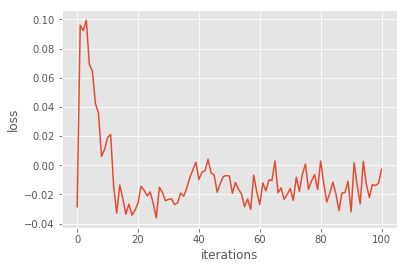

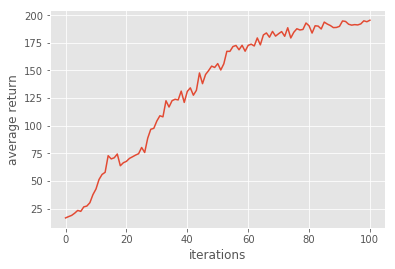

In [5]:
np.random.seed(seed)
tf.set_random_seed(seed)
prng.seed(seed)
env.seed(seed)

tf.reset_default_graph()
sess = tf.Session()
with tf.variable_scope("policy"):
    opt_p = tf.train.AdamOptimizer(learning_rate=0.01)
    policy = CategoricalPolicy(in_dim, out_dim, hidden_dim, opt_p, sess)

sess.run(tf.global_variables_initializer())

n_iter = 200
n_episode = 100
path_length = 200
discount_rate = 0.99
baseline = LinearFeatureBaseline(env.spec)

po = PolicyOptimizer(env, policy, baseline, n_iter, n_episode, path_length,
                     discount_rate)

# Train the policy optimizer
loss_list, avg_return_list = po.train()

util.plot_curve(loss_list, "loss")
util.plot_curve(avg_return_list, "average return")

# Verify your solutions

if you solve the problems 1~3 correctly, your will solve CartPole with roughly ~ 80 iterations.

# Problem 4

Replacing line 

`baseline = LinearFeatureBaseline(env.spec)` 

with 

`baseline = None`

can remove the baseline.

Modify the code to compare the variance and performance before and after adding baseline. And explain why the baseline won't introduce bias. Then, write a report about your findings and explainations. 

/Users/brian/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Iteration 1: Average Return = 16.59
Iteration 2: Average Return = 17.78
Iteration 3: Average Return = 18.54
Iteration 4: Average Return = 21.0
Iteration 5: Average Return = 23.4
Iteration 6: Average Return = 23.3
Iteration 7: Average Return = 25.58
Iteration 8: Average Return = 28.07
Iteration 9: Average Return = 31.3
Iteration 10: Average Return = 36.9
Iteration 11: Average Return = 45.22
Iteration 12: Average Return = 52.95
Iteration 13: Average Return = 55.14
Iteration 14: Average Return = 61.25
Iteration 15: Average Return = 71.94
Iteration 16: Average Return = 81.39
Iteration 17: Average Return = 88.89
Iteration 18: Average Return = 83.89
Iteration 19: Average Return = 70.98
Iteration 20: Average Return = 79.75
Iteration 21: Average Return = 85.25
Iteration 22: Average Return = 80.94
Iteration 23: Average Return = 91.65
Iteration 24: Average Return = 103.62
Iteration 25: Average Return = 92.59
Iteration 26: Average Return = 106.96
Iteration 27: Average Return = 121.39
Iteration 28

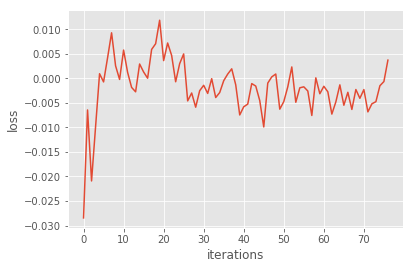

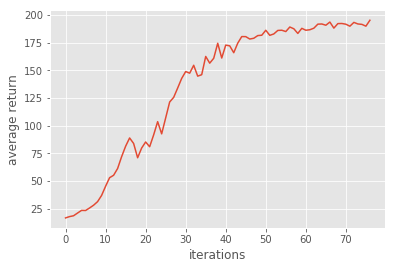

In [7]:
np.random.seed(seed)
tf.set_random_seed(seed)
prng.seed(seed)
env.seed(seed)

tf.reset_default_graph()
sess = tf.Session()
with tf.variable_scope("policy"):
    opt_p = tf.train.AdamOptimizer(learning_rate=0.01)
    policy = CategoricalPolicy(in_dim, out_dim, hidden_dim, opt_p, sess)

sess.run(tf.global_variables_initializer())

n_iter = 200
n_episode = 100
path_length = 200
discount_rate = 0.99
baseline = None

po = PolicyOptimizer(env, policy, baseline, n_iter, n_episode, path_length,
                     discount_rate)

# Train the policy optimizer
loss_list, avg_return_list = po.train()
util.plot_curve(loss_list, "loss")
util.plot_curve(avg_return_list, "average return")

# Problem 5: Actor-Critic algorithm (with bootstrapping)

The baseline reduction lowers the variance without the cost of introducing bias. Are there any others that can reduce the variance of the policy?

In this part, you will implement a simple actor-critic algorithm. Try to overwrite the `process_paths` in `PolicyOptimizer_actor_critic`. Note that the `PolicyOptimizer_actor_critic` inherit the class `PolicyOptimizer`


We use the one-step bootstrap for the advantage function, which change the $A_t^i=(R_t^i-V_t^i)$ in problem 3 into:

$$A_t^i = r_t^i + \gamma*V_{t+1}^i - V_t^i$$

Open **policy_gradient/util.py ** to implement the function `discount_bootstrap`

If you answer is right, your will solve CartPole with roughly ~ 80 iterations.

In [6]:
# set the hyperparameter for generalized advantage estimation (GAE)
LAMBDA = 0.98 # \lambda
class PolicyOptimizer_actor_critic(PolicyOptimizer):
    def __init__(self, env, policy, baseline, n_iter, n_episode, path_length,
        discount_rate=.99):
        PolicyOptimizer.__init__(self, env, policy, baseline, n_iter, n_episode, path_length,
            discount_rate=.99)
    
    def process_paths(self, paths):
        for p in paths:
            if self.baseline != None:
                b = self.baseline.predict(p)
                b[-1] = 0 # terminal state
            else:
                b = 0
            
            """
            1. Variable `b` is the reward predicted by our baseline
            2. Calculate the advantage function via one-step bootstrap
                    A(s, a) = [r(s,a,s') + \gamma*v(s')] - v(s)
            3. `target_v` specifies the target of the baseline function
            """
            r = util.discount_bootstrap(p["rewards"], self.discount_rate, b)
            target_v = util.discount_cumsum(p["rewards"], self.discount_rate)
            a = r - b
            
            p["returns"] = target_v
            p["baselines"] = b
            p["advantages"] = (a - a.mean()) / (a.std() + 1e-8) # normalize

        obs = np.concatenate([ p["observations"] for p in paths ])
        actions = np.concatenate([ p["actions"] for p in paths ])
        rewards = np.concatenate([ p["rewards"] for p in paths ])
        advantages = np.concatenate([ p["advantages"] for p in paths ])

        return dict(
            observations=obs,
            actions=actions,
            rewards=rewards,
            advantages=advantages,
        )

/Users/brian/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Iteration 1: Average Return = 10.08
Iteration 2: Average Return = 10.46
Iteration 3: Average Return = 10.14
Iteration 4: Average Return = 9.85
Iteration 5: Average Return = 10.22
Iteration 6: Average Return = 10.14
Iteration 7: Average Return = 9.87
Iteration 8: Average Return = 10.11
Iteration 9: Average Return = 10.25
Iteration 10: Average Return = 10.15
Iteration 11: Average Return = 10.26
Iteration 12: Average Return = 10.5
Iteration 13: Average Return = 10.48
Iteration 14: Average Return = 10.22
Iteration 15: Average Return = 10.57
Iteration 16: Average Return = 10.9
Iteration 17: Average Return = 10.26
Iteration 18: Average Return = 10.56
Iteration 19: Average Return = 10.62
Iteration 20: Average Return = 10.4
Iteration 21: Average Return = 10.76
Iteration 22: Average Return = 10.52
Iteration 23: Average Return = 10.58
Iteration 24: Average Return = 10.59
Iteration 25: Average Return = 10.72
Iteration 26: Average Return = 10.81
Iteration 27: Average Return = 11.24
Iteration 28: A

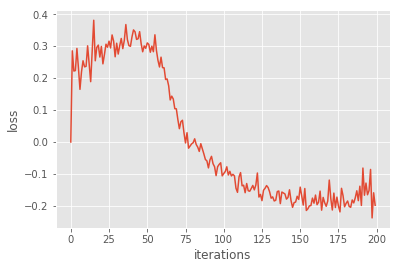

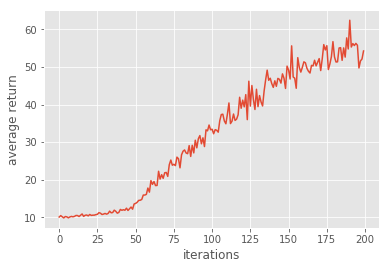

In [16]:
np.random.seed(seed)
tf.set_random_seed(seed)
prng.seed(seed)
env.seed(seed)

tf.reset_default_graph()
sess = tf.Session()
with tf.variable_scope("policy"):
    opt_p = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    policy = CategoricalPolicy(in_dim, out_dim, hidden_dim, opt_p, sess)

sess.run(tf.global_variables_initializer())

n_iter = 200
n_episode = 100
path_length = 200
discount_rate = 0.99
# reinitialize the baseline function
baseline = LinearFeatureBaseline(env.spec) 
sess.run(tf.global_variables_initializer())
po = PolicyOptimizer_actor_critic(env, policy, baseline, n_iter, n_episode, path_length,
                     discount_rate)

# Train the policy optimizer
loss_list, avg_return_list = po.train()

util.plot_curve(loss_list, "loss")
util.plot_curve(avg_return_list, "average return")

# Problem 6: Generalized Advantage Estimation

In Problem 3, we calculate the advantage function with **the total return substract the baseline** 

In Problem 5, we calculate the advantage function based on Problem 3, and **replace the total return with the immediate reward plus estimated baseline**

Here, we use a novel advantage function called "Generalized Advantage Estimation", which introduces one hyperparameter $\lambda$ to compromise the above two estimation methods.

Assume the $\delta_t^i$ represent the i-step bootstrapping (e.g. $\delta_t^i=r_t^i + \gamma*V_{t+1}^i - V_t^i$). The generalized advantage estimation will be:

$$A_{t}^{GAE} = \sum_{l=0}^{\infty} (\gamma\lambda)^l \delta_{t+1}$$

Please see [High-Dimensional Continuous Control Using Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438) for details.


If you answer is right, your will solve CartPole with roughly ~ 80 iterations.

In [7]:
# set the hyperparameter for generalized advantage estimation (GAE)
LAMBDA = 0.98 # \lambda
class PolicyOptimizer_actor_critic(PolicyOptimizer):
    def __init__(self, env, policy, baseline, n_iter, n_episode, path_length,
        discount_rate=.99):
        PolicyOptimizer.__init__(self, env, policy, baseline, n_iter, n_episode, path_length,
            discount_rate=.99)
    
    def process_paths(self, paths):
        for p in paths:
            if self.baseline != None:
                b = self.baseline.predict(p)
                b[-1] = 0 # terminal state
            else:
                b = 0
            
            """
            1. Variable `b` is the reward predicted by our baseline
            2. Calculate the advantage function via one-step bootstrap
                    A(s, a) = [r(s,a,s') + \gamma*v(s')] - v(s)
            3. `target_v` specifies the target of the baseline function
            """
            r = util.discount_bootstrap(p["rewards"], self.discount_rate, b)
            target_v = util.discount_cumsum(p["rewards"], self.discount_rate)
            a = r - b
            
            """
            Problem 6 (Skip this when doing Proble): 
            
            1. in Problem 3, we calculate the advantage function with the total 
                       return substract the baseline 
               in Problem 5, we calculate the advantage function based on Problem 3. 
                       And replace the total return with the immediate reward plus estimated baseline
            2. Here, we use a novel advantage function called "Generalized Advantage Estimation", 
                       which introduces one hyperparameter to balance the above two estimation methods.
            Currently, the variable `LAMBDA` is the default hyperparameter for GAE. 
                        (You're encouraged to try other \lambda=[0,1])
            Sample solution should be only 1 line. (you can use `util.discount` in policy_gradient/util.py)
            """
            # YOUR CODE HERE >>>>>>>>
            """
            y[0] = x[0] + discount(x[1],1) + discount(x[2],2) + ... + discount(x[len(x)-1], len(x)-1)
            y[1] = x[1] + discount(x[2],1) + discount(x[3],2) + ... + discount(x[len(x)-1], len(x)-2)
            ...
            y[n] = x[n] + discount(x[n], 1) + ... + discount(x[len(x)-1], len(x)-n+1)
                 = x[n] + discount(y[n+1],1)
            """
            a = util.discount(a, discount_rate*LAMBDA)
            # <<<<<<<
            p["returns"] = target_v
            p["baselines"] = b
            p["advantages"] = (a - a.mean()) / (a.std() + 1e-8) # normalize

        obs = np.concatenate([ p["observations"] for p in paths ])
        actions = np.concatenate([ p["actions"] for p in paths ])
        rewards = np.concatenate([ p["rewards"] for p in paths ])
        advantages = np.concatenate([ p["advantages"] for p in paths ])

        return dict(
            observations=obs,
            actions=actions,
            rewards=rewards,
            advantages=advantages,
        )

/Users/brian/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Iteration 1: Average Return = 10.08
Iteration 2: Average Return = 10.65
Iteration 3: Average Return = 10.43
Iteration 4: Average Return = 10.24
Iteration 5: Average Return = 10.9
Iteration 6: Average Return = 11.8
Iteration 7: Average Return = 11.62
Iteration 8: Average Return = 12.78
Iteration 9: Average Return = 14.62
Iteration 10: Average Return = 17.71
Iteration 11: Average Return = 21.66
Iteration 12: Average Return = 24.08
Iteration 13: Average Return = 29.15
Iteration 14: Average Return = 35.26
Iteration 15: Average Return = 38.5
Iteration 16: Average Return = 36.95
Iteration 17: Average Return = 37.7
Iteration 18: Average Return = 38.53
Iteration 19: Average Return = 32.56
Iteration 20: Average Return = 34.28
Iteration 21: Average Return = 36.93
Iteration 22: Average Return = 34.85
Iteration 23: Average Return = 39.25
Iteration 24: Average Return = 40.84
Iteration 25: Average Return = 45.73
Iteration 26: Average Return = 42.62
Iteration 27: Average Return = 49.18
Iteration 28: 

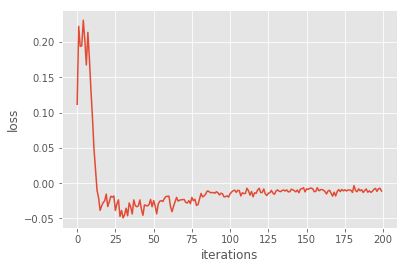

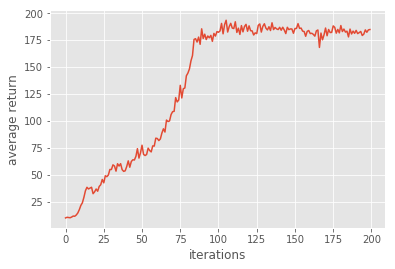

In [8]:
np.random.seed(seed)
tf.set_random_seed(seed)
prng.seed(seed)
env.seed(seed)

tf.reset_default_graph()
sess = tf.Session()
with tf.variable_scope("policy"):
    opt_p = tf.train.AdamOptimizer(learning_rate=0.01)
    policy = CategoricalPolicy(in_dim, out_dim, hidden_dim, opt_p, sess)

sess.run(tf.global_variables_initializer())

n_iter = 200
n_episode = 100
path_length = 200
discount_rate = 0.99
# reinitialize the baseline function
baseline = LinearFeatureBaseline(env.spec) 
sess.run(tf.global_variables_initializer())
po = PolicyOptimizer_actor_critic(env, policy, baseline, n_iter, n_episode, path_length,
                     discount_rate)

# Train the policy optimizer
loss_list, avg_return_list = po.train()

util.plot_curve(loss_list, "loss")
util.plot_curve(avg_return_list, "average return")